In [179]:
# Import library yang diperlukan
import cv2
import numpy as np
import os
from skimage.feature import graycomatrix, graycoprops
import pandas as pd 
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.subplots as sp
import PIL.Image as pimage
from IPython.display import Image


import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

# Pra proses

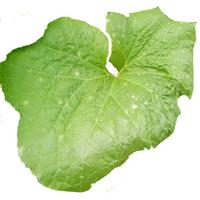

In [180]:
# Path ke folder yang berisi citra
folder_path = './resize_mleaves/'
raw_folder_path = './melon_leaves/'
image_files = os.listdir(folder_path)

Image(filename=folder_path+image_files[5]) 

In [181]:
imgs_matrix = [] #list image matrix 
imgs_label = [] #image path
for filename in image_files:
    image = cv2.imread(folder_path+filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape
    ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
    crop = gray[ymin:ymax, xmin:xmax]

    resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)

    imgs_matrix.append(resize)
    imgs_label.append(filename)

In [182]:
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
# what happen if there is some change in parameter GLCM?, distance=4? and levels, what commonly value used?
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = graycomatrix(
        img, 
        distances=dists, 
        angles=agls, 
        levels=lvl,
        symmetric=sym, 
        normed=norm
    )
    feature = []
    feature.append(label) #append label

    # append GLCM properties
    # glcm_props = []
    # for name in props:
    #     for property in graycoprops(glcm, name)[0]:
    #           glcm_props.append(property)
    # for item in glcm_props:
    #         feature.append(item)
    glcm_props = []
    for prop in props:
        from_graycoprops = graycoprops(glcm, prop) # shape array (1, 4)
        glcm_props.extend(from_graycoprops[0])
    feature.extend(glcm_props)

    
    return feature

In [183]:
# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img,label in zip(imgs_matrix, imgs_label): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, label, props=properties)
            )

In [184]:
# Create the pandas DataFrame for GLCM features data
# column
columns = []
columns.append("label") #label column
# GLCM column
angles = ['0', '45', '90','135']
for name in properties:
    for ang in angles:
        columns.append(name + "_" + ang)

# create dataframe
glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df.head(15)

,label,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,...,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135
0,IMG_20210223_102008.jpg,13.342799,14.581111,11.881339,12.254444,0.377597,0.246085,0.467136,0.425482,0.079451,...,226.956389,262.234444,0.000956,0.001067,0.001076,0.001102,0.030921,0.032669,0.032809,0.033194
1,IMG_20210223_102746.jpg,26.336714,27.195556,23.474645,27.345556,0.236763,0.204441,0.417236,0.200688,0.036713,...,872.405680,1183.234444,0.000661,0.000699,0.000633,0.000669,0.025717,0.026446,0.025162,0.025868
2,IMG_20200224_132619.jpg,14.716024,13.613333,10.461460,14.254444,0.720002,0.739957,0.831399,0.727882,0.070532,...,211.745436,332.941111,0.000782,0.000854,0.000896,0.000892,0.027969,0.029218,0.029940,0.029866
3,IMG_20200224_132816.jpg,15.307302,17.343333,17.998986,16.877778,0.762113,0.696468,0.673362,0.718668,0.071681,...,521.867140,457.660000,0.000690,0.000741,0.000638,0.000691,0.026271,0.027217,0.025253,0.026294
4,IMG_20210329_13252995.jpg,19.645030,20.323333,18.391481,20.748889,0.124446,0.294564,0.515840,0.049762,0.089755,...,1647.054767,2186.920000,0.001075,0.001022,0.001020,0.001098,0.032785,0.031972,0.031935,0.033129
5,IMG_20200224_132427.jpg,14.936105,13.477778,13.502028,12.463333,0.147289,0.397122,0.296411,0.339640,0.091638,...,393.522312,377.416667,0.000971,0.001025,0.001010,0.001125,0.031161,0.032011,0.031782,0.033546
6,IMG_20210223_101844.jpg,18.191684,14.267778,14.506085,19.367778,0.292248,0.525307,0.576097,0.205702,0.057966,...,369.218053,656.625556,0.000787,0.000961,0.000836,0.000867,0.028051,0.031002,0.028909,0.029450
7,IMG_20210329_132235.jpg,11.429006,10.481111,8.688641,11.370000,0.200086,0.274946,0.548768,0.200701,0.085372,...,119.353955,212.116667,0.001267,0.001434,0.001356,0.001331,0.035598,0.037868,0.036820,0.036489
8,IMG_20210223_102418.jpg,14.404665,14.617778,13.401623,14.063333,0.277666,0.274844,0.366783,0.317579,0.067287,...,301.756592,319.485556,0.000868,0.000945,0.000916,0.000965,0.029464,0.030742,0.030265,0.031071
9,IMG_20210223_102342.jpg,6.044625,6.601111,5.987830,5.254444,0.497210,0.329406,0.491040,0.589563,0.147782,...,62.198783,45.981111,0.002521,0.002327,0.002273,0.002677,0.050205,0.048234,0.047678,0.051741


In [185]:
glcm_df.shape

(160, 25)

In [ ]:
# Filter hanya kolom yang berakhiran "_0"
filtered_columns = [col for col in glcm_df.columns if col.endswith('_135')]
glcm_df[filtered_columns]

# Reduksi Dimensi


In [187]:
# X = glcm_df.drop(['label'], axis=1)
X = glcm_df[filtered_columns]
Y = glcm_df['label']

# UMAP reduction
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_scaled = UMAP().fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=['feature-vector-1','feature-vector-2'])

In [188]:
# Membuat scatter plot dengan Plotly
fig = go.Figure()

# Menambahkan scatter plot
fig.add_trace(
    go.Scatter(x=X_scaled['feature-vector-1'], y=X_scaled['feature-vector-2'], mode='markers', marker=dict(size=10))
)

# Menyamakan skala sumbu x dan y
fig.update_xaxes(scaleanchor="y")
fig.update_yaxes(scaleanchor="x")

# Menambahkan judul
fig.update_layout(title="Scatter Plot")

# Menampilkan plot
fig.show()


# ELBOW Analysis 

In [189]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

### Inertia

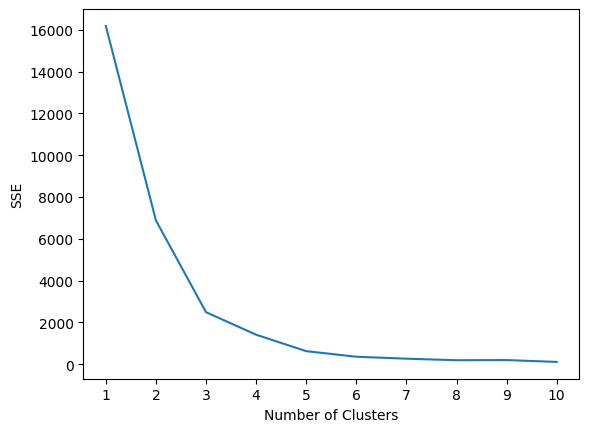

In [190]:
#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhoutte score

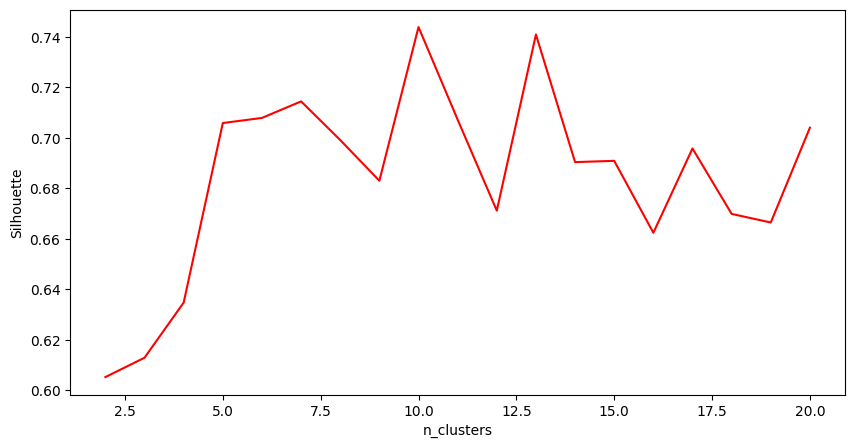

In [191]:
score = []
k_range = range(2, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    member = kmeans.fit_predict(X_scaled)

    siluet = silhouette_score(X_scaled, member, metric='euclidean')
    score.append(siluet)
    
plt.figure(figsize=(10, 5))
plt.plot (k_range, score, "r-")
plt. ylabel ("Silhouette" )
plt.xlabel ("n_clusters");

# K-MEANS

In [172]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
cluster = kmeans.fit_predict(X_scaled)
centroid = kmeans.cluster_centers_

In [173]:
cluster

array([7, 0, 2, 1, 9, 2, 3, 7, 2, 8, 9, 1, 2, 8, 8, 2, 3, 2, 5, 2, 2, 0,
       1, 1, 9, 2, 1, 1, 7, 1, 1, 7, 6, 2, 2, 6, 9, 5, 3, 8, 5, 2, 1, 4,
       8, 8, 1, 2, 7, 2, 4, 0, 7, 4, 1, 6, 3, 6, 3, 1, 1, 4, 1, 3, 3, 3,
       7, 4, 9, 2, 6, 0, 7, 2, 7, 3, 3, 4, 1, 2, 5, 8, 5, 0, 0, 3, 2, 7,
       2, 3, 4, 1, 9, 7, 1, 8, 5, 7, 1, 5, 6, 3, 2, 1, 1, 1, 5, 5, 9, 5,
       6, 6, 7, 2, 1, 3, 3, 0, 1, 1, 1, 3, 5, 9, 9, 3, 1, 9, 6, 3, 0, 5,
       4, 9, 8, 7, 2, 7, 6, 4, 3, 0, 4, 1, 8, 7, 7, 1, 5, 4, 8, 6, 1, 5,
       3, 1, 8, 8, 7, 4], dtype=int32)

In [174]:

# Buat scatter plot untuk data
scatter = go.Scatter(x=X_scaled['feature-vector-1'], y=X_scaled['feature-vector-2'], mode='markers', marker=dict(color=cluster, size=10))

# Buat scatter plot untuk centroid
centroid_scatter = go.Scatter(
    x=centroid[:, 0], y=centroid[:, 1], mode='markers', marker=dict(
            color="white", 
            size=10, 
            symbol='triangle-up',  # Menggunakan simbol 'star' untuk tanda
            line=dict(color="black", width=2)
        )
)

# Buat figure dan tambahkan scatter plots
fig = go.Figure(data=[scatter, centroid_scatter])

# Set axis aspect ratio
fig.update_xaxes(scaleratio=1)
fig.update_yaxes(scaleratio=1)

# Tampilkan plot
fig.show()

In [175]:
X_scaled['label']=Y
X_scaled['cluster']=cluster
X_scaled

,feature-vector-1,feature-vector-2,label,cluster
0,-7.127936,8.255295,IMG_20210223_102008.jpg,7
1,15.784226,6.087157,IMG_20210223_102746.jpg,0
2,-4.748159,7.395695,IMG_20200224_132619.jpg,2
3,2.487162,-0.899693,IMG_20200224_132816.jpg,1
4,15.277506,8.313323,IMG_20210329_13252995.jpg,9
...,...,...,...,...
155,0.162744,-0.596666,IMG_20210329_13252998.jpg,1
156,-11.157375,16.088978,IMG_20210223_102603.jpg,8
157,-11.224672,15.726278,IMG_20200224_132833.jpg,8
158,-8.576056,9.167623,IMG_20200224_131902.jpg,7


In [176]:
X_scaled.to_csv('result_k=7_GLCMangle=0.csv', index=False)

In [177]:
# Daftar path file gambar
image_paths = []
for k in X_scaled.cluster.unique():
    cluster_data = X_scaled[X_scaled['cluster'] == k]
    # random_sample = cluster_data.sample(1, random_state=42)  # Ganti random_state sesuai kebutuhan Anda
    # label = random_sample.iloc[0].label
    # image_paths.append(raw_folder_path + label)
    label = cluster_data.iloc[0].label
    image_paths.append(raw_folder_path + label)

# Buat subplot grid
fig = sp.make_subplots(rows=2, cols=3)

# Loop melalui setiap path file gambar dan tambahkan ke subplot
for i, image_path in enumerate(image_paths):
    img = pimage.open(image_path)
    trace = go.Image(z=img)
    row = i // 3 + 1
    col = i % 3 + 1
    fig.add_trace(trace, row=row, col=col)

# Konfigurasi tata letak subplot
fig.update_layout(
    title='Grid Subplots of Images',
    showlegend=False,
    height=600,
    width=900
)

# Menampilkan plot
fig.show()


Exception: The (row, col) pair sent is out of range. Use Figure.print_grid to view the subplot grid. 

# Notes
- compare 4,5,6, cluste which one is the best? add silhouete score or other evaluation method
- group the images based on cluster (folder), and ask the expert opinion
- we need to evaluate using metric to define how the performance, or validated by expert, not manualy check 
- add explanation/reasoning about GLCM. from scientific article 
- finding another work about clustering/clasification Golden Melon Leaf compare to our work.

Categorizatioin, Golden Melon Leaf

Evaluation methods than can be used:
- Silhouette Score
- Inertia (Within-Cluster Sum of Squares)
- Dunn Index